In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# import the data
data = pd.read_csv('../Measurements/s02_210218_white.csv')

In [3]:
# removing extra columns and seting time as the index
data = data.drop('Unnamed: 0', axis=1)
data.index = data.Time
data = data.drop('Time', axis=1)

In [4]:
# a function for faster plotting
def plotIt(data=None, title='', xlabel='', ylabel='', figsize=(15,10), plot_hist=False):
    if plot_hist:
        data.plot.hist(figsize=figsize)
    
    else:
        data.plot(figsize=figsize)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.show()

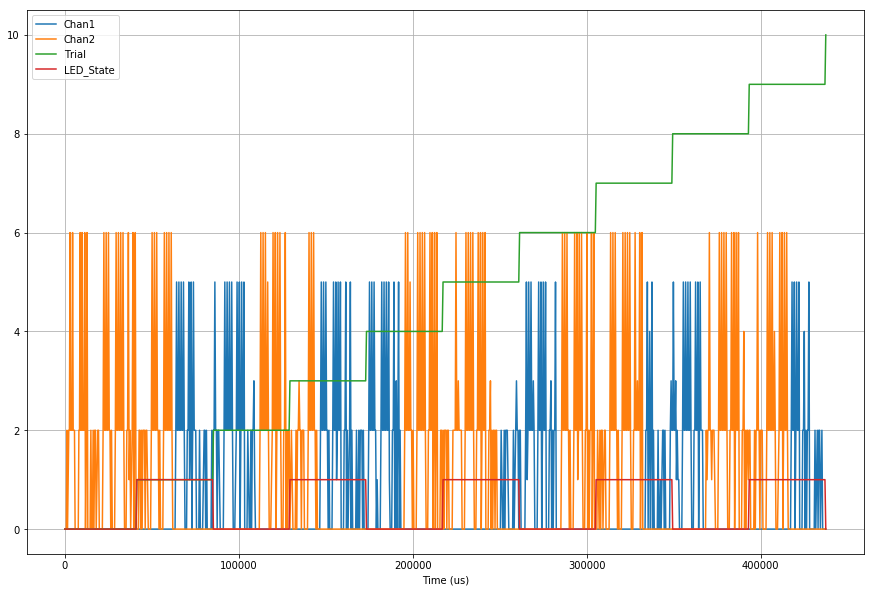

In [5]:
plotIt(data[:1000], xlabel='Time (us)')

### Smoothing

In [6]:
data['Chan1'] = data.Chan1.rolling(9, center=True).max()
data['Chan2'] = data.Chan2.rolling(9, center=True).max()
data['Chan1'][data['Chan1'] > .5] = 5 # 5 is an arbitrary value
data['Chan2'][data['Chan2'] > .5] = 5

c:\users\mohammad bashiri\anaconda3\envs\detector\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\mohammad bashiri\anaconda3\envs\detector\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


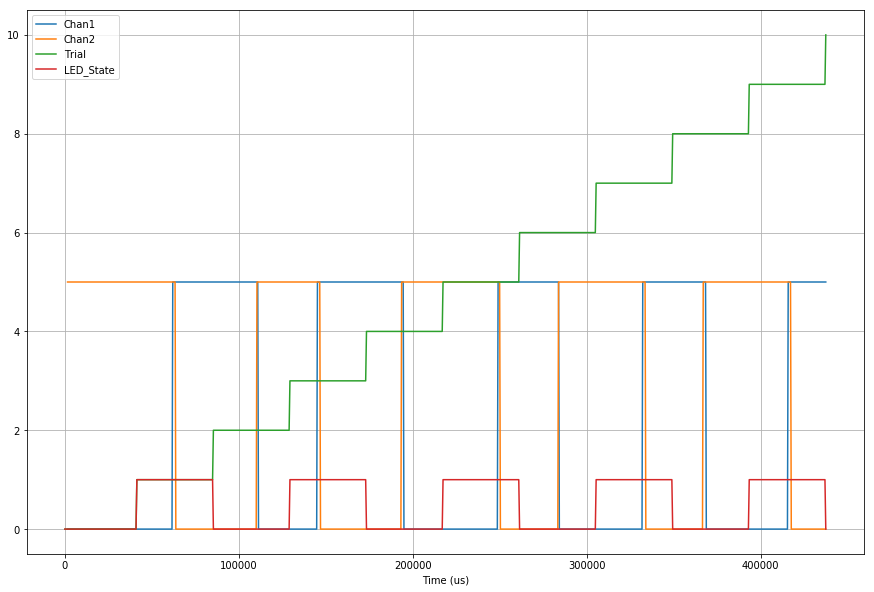

In [7]:
plotIt(data[:1000], xlabel='Time (us)')

In [8]:
# taking the difference to mark the staring points
data.Chan1 = data.Chan1.diff()
data.Chan2 = data.Chan2.diff()

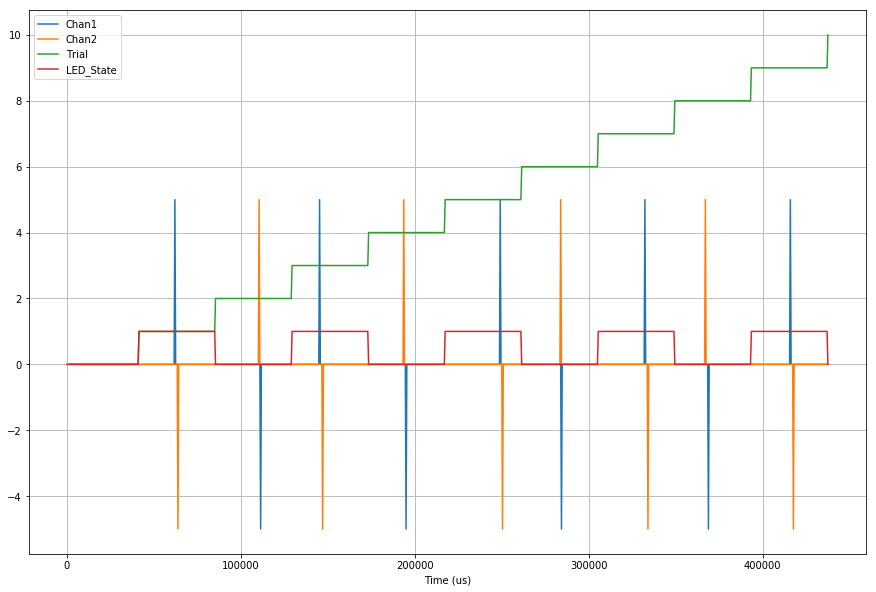

In [9]:
plotIt(data[:1000], xlabel='Time (us)')

In [10]:
# dealing with the NaNs, as a result of diff()
data[data.isna()] = 0

## Both channels (Grouping based on 'trial number')

In [159]:
grouped = data.groupby('Trial')

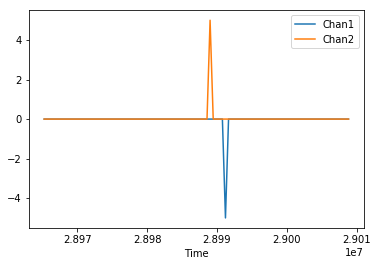

In [160]:
df = grouped.get_group(658)
df[['Chan1', 'Chan2']].plot()

In [161]:
latency.shape[0]

660

In [162]:
len(keys_list)

657

In [163]:
# remove the groups, if needed
keys_list = list(grouped.indices.keys())
keys_list.remove(0)
keys_list.remove(92)
keys_list.remove(94)

In [203]:
latency = np.zeros((len(keys_list)+3,))
for key in keys_list[1:]:
#     print(key)
    if(grouped.get_group(key).LED_State.as_matrix()[0]): # chan1 when LED_State == 1
        latency[key] = grouped.get_group(key).index[0] - grouped.get_group(key).index[grouped.get_group(key).Chan1 != 0][0]
    else: # chan2 when LED_State == 0
        latency[key] = grouped.get_group(key).index[0] - grouped.get_group(key).index[grouped.get_group(key).Chan2 != 0][0]

In [204]:
key

659

In [205]:
# make the latencies absolute value
latency = np.abs(latency)

In [209]:
# remove the 0s
latency = np.delete(latency, np.where(latency==0)[0]);

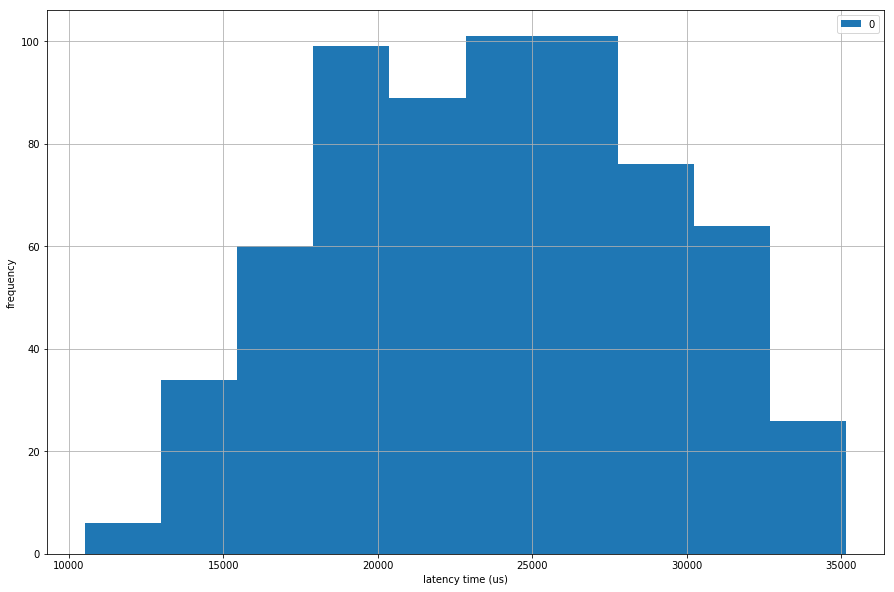

In [210]:
plotIt(pd.DataFrame(latency), xlabel='latency time (us)', ylabel='frequency', plot_hist=True)

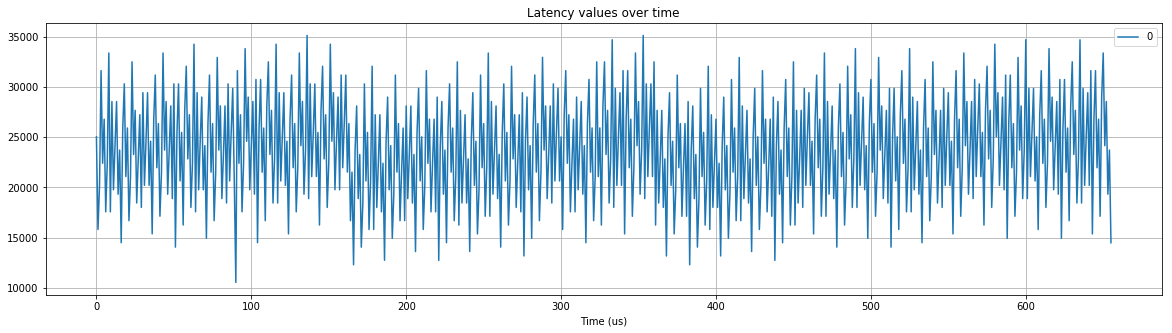

In [211]:
plotIt(
    pd.DataFrame(latency), 
    xlabel='Time (us)', 
    title='Latency values over time', 
    figsize=(20,5)
)

## For separate channels (grouping based on Trial and LED_State)

In [147]:
grouped = data.groupby(['LED_State', 'Trial'])

In [148]:
levels = grouped.size().index.levels[0]

In [149]:
latency = np.zeros((len(levels), sum(grouped.size().index.labels[0] == 1)))
for key in grouped.indices.keys():
    if key[0]:
        latency[key[0], key[1]//len(levels)] = grouped.get_group(key).index[0] - grouped.get_group(key).index[grouped.get_group(key).Chan1 != 0][0]
    else:
        latency[key[0], key[1]//len(levels)] = grouped.get_group(key).index[0] - grouped.get_group(key).index[grouped.get_group(key).Chan2 != 0][0]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [19]:
latency = np.abs(latency)

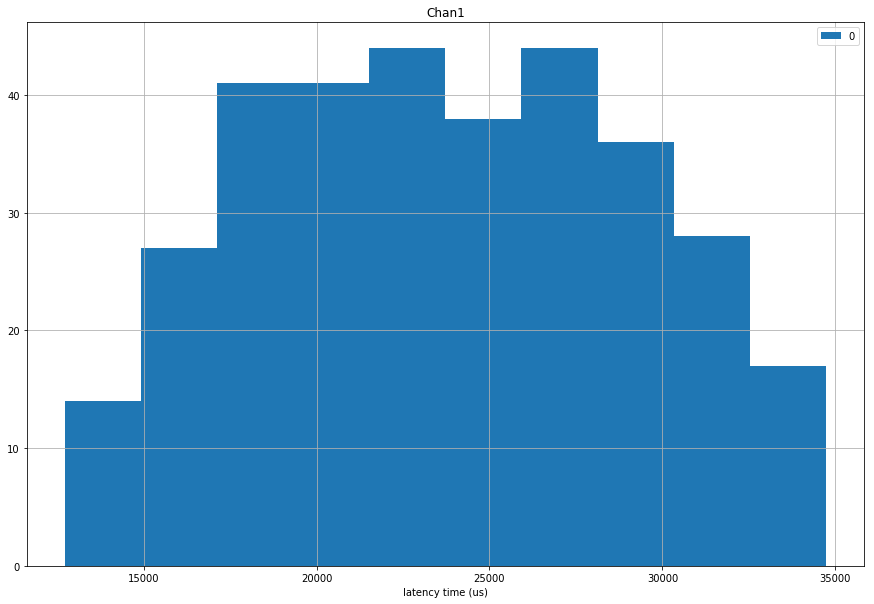

In [20]:
plotIt(
    pd.DataFrame(latency[0,:]), 
    title='Chan1',
    xlabel='latency time (us)',
    plot_hist=True)

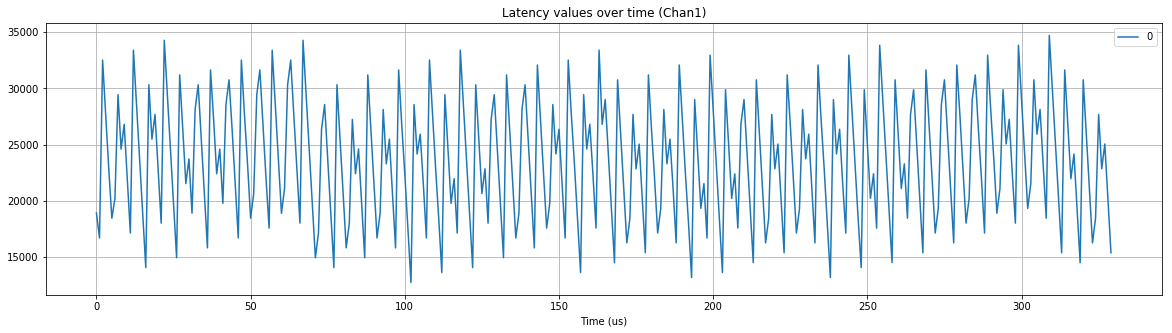

In [21]:
plotIt(
    pd.DataFrame(latency[0,:]), 
    xlabel='Time (us)', 
    title='Latency values over time (Chan1)', 
    figsize=(20,5)
)

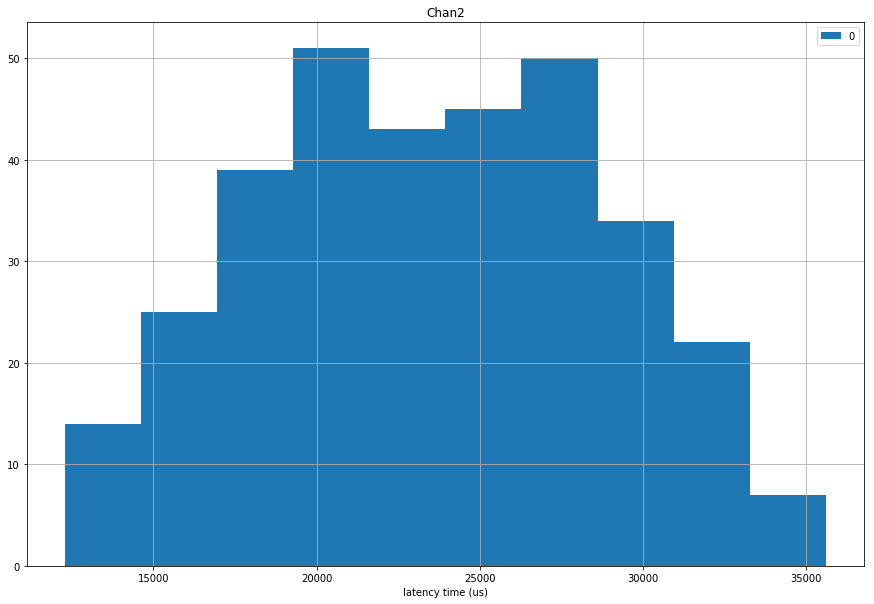

In [22]:
plotIt(
    pd.DataFrame(latency[1,:]), 
    title='Chan2',
    xlabel='latency time (us)',
    plot_hist=True)

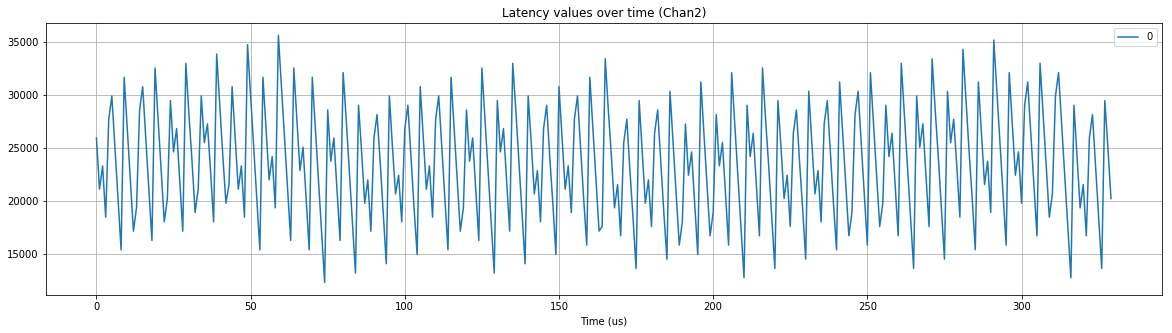

In [23]:
plotIt(
    pd.DataFrame(latency[1,:]), 
    xlabel='Time (us)', 
    title='Latency values over time (Chan2)', 
    figsize=(20,5)
)

# How does smoothing infleunces this value?

- Sampling frequency = fs
- Rolling value = 9, centered=True

Then, the value present at any point in the smoothened signal, might be shifter 10/2 samples forward. To be safe, we are gonna consider the worst case scenario, that is:

floor(9/2) * 1/fs

In [24]:
# finding the worst case sampling frequency
timing_data = data.index.values
timing_data_diff = np.diff(timing_data)
fs = 1/(np.max(timing_data_diff)*10**-6)
fs

2066.115702479339

In [25]:
9//2 * 1/fs

0.001936

So in this case there is could be maximum error of around 2 ms